# Gower distance was used for both K-medoids and DBSCAN
# Kmeans was tested for experimental reasons


In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
from google.colab import files

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
uploaded = files.upload()

Saving CDN Client Error.csv to CDN Client Error.csv


In [3]:
# We verify that the files are correctly downloaded
!ls -l 

total 3180
-rw-r--r-- 1 root root 3248257 Nov 30 11:17 'CDN Client Error.csv'
drwxr-xr-x 1 root root    4096 Nov 18 14:36  sample_data


In [4]:
# Combine these datasets
df = pd.read_csv('CDN Client Error.csv')

In [5]:
df.head()

,channel_id,timestamp,host_id,content_type,protocol,content_id,geo_location,user_id
0,0,2088-05-13 09:19:11,156,8,1,NaN,1303,0.0
1,0,2088-05-13 08:58:12,156,8,1,NaN,1514,0.0
2,0,2088-05-13 09:39:05,156,2,1,NaN,1,13.0
3,0,2088-05-13 09:54:15,156,8,1,NaN,1,0.0
4,0,2088-05-13 10:04:32,156,8,1,NaN,1,0.0


In [6]:
df.shape

(88435, 8)

In [7]:
df.dtypes

channel_id        int64
timestamp        object
host_id           int64
content_type      int64
protocol          int64
content_id      float64
geo_location      int64
user_id         float64
dtype: object

In [8]:
# change the type of timestamp column
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [9]:
#replace NaN values with -1
df = df.fillna(-1)

In [10]:
# set timestamp to index
#df.set_index('timestamp', drop=True, inplace=True)
# resample timeseries to hourly 
#df = df.resample('H').sum()

# create features from date
df['day'] = [df['timestamp'].iloc[i].day for i in df.index]
#df['day_name'] = [i.day_name() for i in df.index]
#df['day_of_year'] = [i.dayofyear for i in df.index]
#df['week_of_year'] = [i.weekofyear for i in df.index]
df['hour'] = [df['timestamp'].iloc[i].hour for i in df.index]
df['is_weekday'] = [df['timestamp'].iloc[i].isoweekday() for i in df.index]

In [11]:
df.head()

,channel_id,timestamp,host_id,content_type,protocol,content_id,geo_location,user_id,day,hour,is_weekday
0,0,2088-05-13 09:19:11,156,8,1,-1.0,1303,0.0,13,9,4
1,0,2088-05-13 08:58:12,156,8,1,-1.0,1514,0.0,13,8,4
2,0,2088-05-13 09:39:05,156,2,1,-1.0,1,13.0,13,9,4
3,0,2088-05-13 09:54:15,156,8,1,-1.0,1,0.0,13,9,4
4,0,2088-05-13 10:04:32,156,8,1,-1.0,1,0.0,13,10,4


# Chi2 for feature selection

In [12]:
from scipy.stats import chi2_contingency, ttest_ind

feature = []
p = []
chi_2 = []
categorical_vars = ['channel_id', 'host_id','content_type', 'protocol','content_id','geo_location','user_id','is_weekday']
for i in categorical_vars[:-1]:
    feature.append(i)
    result =chi2_contingency( pd.crosstab(df['content_id'],df[i]))
    p.append(round(float(result[1]),6))   
    if float(result[1]) < 0.01:
        chi_2.append("Significant")
    else:
        chi_2.append("Insignificant")

In [13]:
chi = pd.DataFrame(data={'P value':p,'Significance':chi_2},index=feature)
chi

,P value,Significance
channel_id,0.000000,Significant
host_id,1.000000,Insignificant
content_type,0.000000,Significant
protocol,0.997477,Insignificant
content_id,0.000000,Significant
geo_location,0.000000,Significant
user_id,0.000000,Significant


Evaluating the correlation matrix, we can also see that content_id is highly correlated with host_id and protocol, so those can be dropped 

In [14]:
#drop unsignificant features
df = df.drop(columns = chi[chi['Significance'] == 'Insignificant'].index, axis=1)

In [15]:
df = df.drop(columns = 'timestamp', axis=1)

# Kmeans

K-Medoids clusters


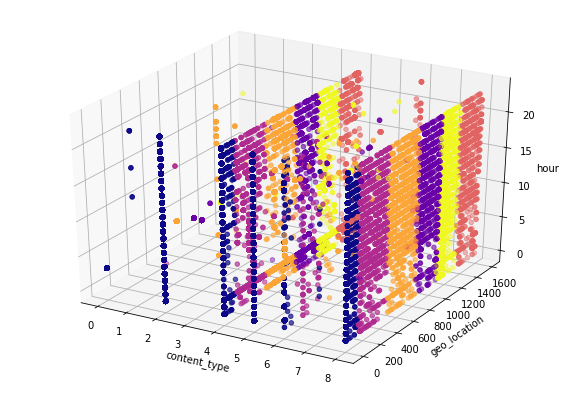

In [16]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
model = KMeans(n_clusters = 6, random_state = 0).fit(df)
kmMeans_labels = model.labels_

fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection="3d")

ax.scatter3D(df['content_type'],df['geo_location'],df['hour'],c=kmMeans_labels, cmap='plasma')
xLabel = ax.set_xlabel('content_type', linespacing=2)
yLabel = ax.set_ylabel('geo_location', linespacing=2)
zLabel = ax.set_zlabel('hour', linespacing=2)
print("K-Medoids clusters")

# Silhouette

n = 2  : average silhouette_score : 0.859


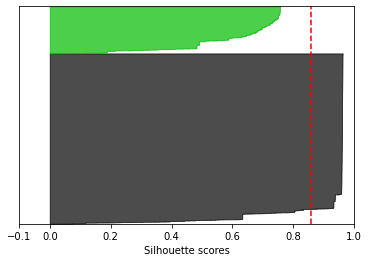

n = 3  : average silhouette_score : 0.846


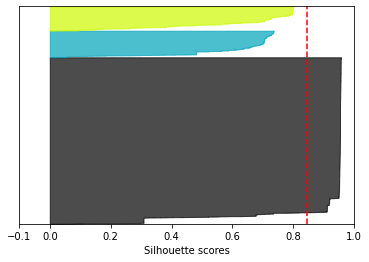

n = 4  : average silhouette_score : 0.833


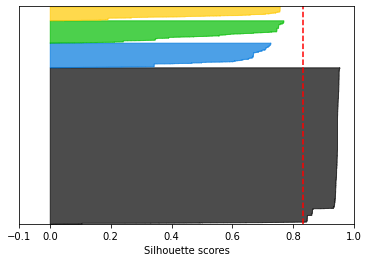

n = 5  : average silhouette_score : 0.836


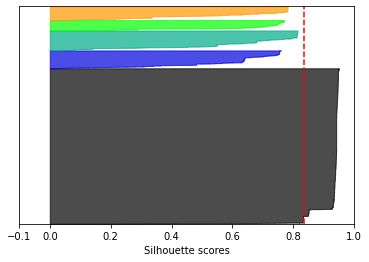

n = 6  : average silhouette_score : 0.835


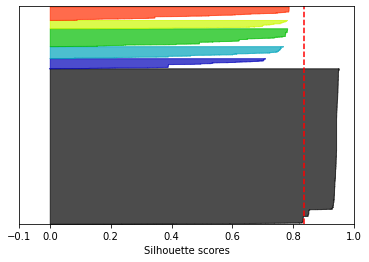

In [17]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = [2, 3, 4, 5, 6]
for n in range_n_clusters:
    plt.xlim([-0.1, 1])
    plt.ylim([0, len(df) + (n + 1) * 10])
    method = KMeans(n_clusters = n).fit(df)
    cluster_labels = method.fit_predict(df)
    avg = silhouette_score(df, cluster_labels)
    print("n =", n," : average silhouette_score :", round(avg,3))
    sample_values = silhouette_samples(df, cluster_labels)
    y_lower = 10
    for i in range(n):
        ith_cluster = \
            sample_values[cluster_labels == i]
        ith_cluster.sort()
        size_i = ith_cluster.shape[0]
        y_upper = y_lower + size_i
        color = cm.nipy_spectral(float(i) / n)
        plt.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster,facecolor=color, edgecolor=color, alpha=0.7)
        y_lower = y_upper + 10 
    plt.xlabel("Silhouette scores")
    plt.axvline(x=avg, color="red", linestyle="--")
    plt.yticks([])  
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

Kmeans had high average silhouette scores but this is due to the unbalanced distribution of data points accross clusters. Kmeans is not suitable for our dataset with almost only categorical features

# K-medoids/DBSCAN with Gower distance

In [18]:
!pip install gower
!pip install scikit-learn-extra

  Created wheel for gower: filename=gower-0.0.5-py3-none-any.whl size=4231 sha256=238b35977288e85ce5053115e0e22b0035a3e10549fba602098dd9e629221eba
  Stored in directory: /root/.cache/pip/wheels/3e/f9/9a/67122a959a424e9cbb4557a8366c871a30e31cd75f0d003db4
Successfully built gower
     |████████████████████████████████| 1.7 MB 5.1 MB/s 


In [19]:
#taking a portion of data to test gower distance
#gower may be inefficient because data is big and it takes time to be encoded
data=df[:10000]

In [20]:
import gower
from sklearn_extra.cluster import KMedoids
gower_mat = gower.gower_matrix(data,  cat_features = [True,True ,True,True, True,False,False,True])

# Kmedoids

No need for encoding here as gower handles both numerical and categorical data types

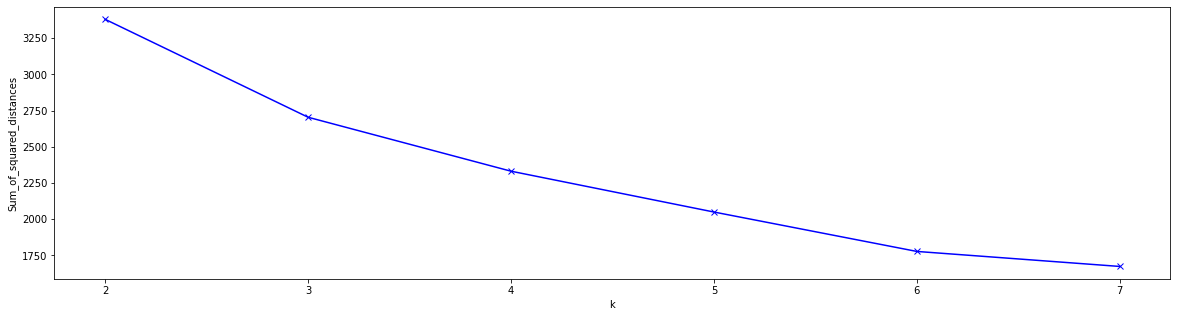

In [21]:
Sum_of_squared_distances = []
K = range(2,8)
for k in K:
    km = KMedoids(n_clusters = k, random_state = 0,  metric = 'precomputed', method = 'pam', init =  'k-medoids++').fit(gower_mat)
    Sum_of_squared_distances.append(km.inertia_)
plt.figure(figsize=(20,5))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.show()

K=6 is the optimal number of clusters according to the elbow method

K-Medoids clusters


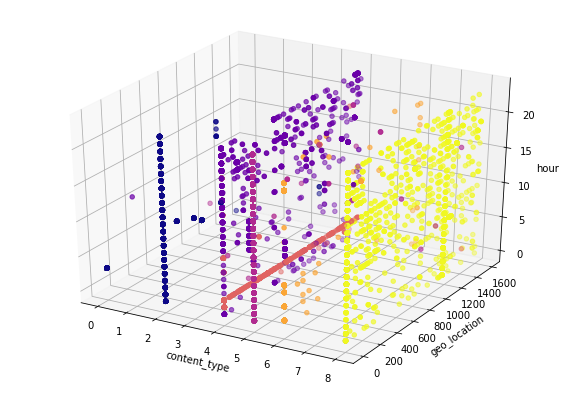

In [22]:
from mpl_toolkits.mplot3d import Axes3D

model = KMedoids(n_clusters = 6, random_state = 0, metric = 'precomputed', method = 'pam', init =  'k-medoids++').fit(gower_mat)
kmedoids_labels = model.labels_

fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection="3d")
ax.scatter3D(data['content_type'],data['geo_location'],data['hour'],c=kmedoids_labels, cmap='plasma')
xLabel = ax.set_xlabel('content_type', linespacing=2)
yLabel = ax.set_ylabel('geo_location', linespacing=2)
zLabel = ax.set_zlabel('hour', linespacing=2)
print("K-Medoids clusters")

# Silhouette internal evaluation for kmedoids

n = 2  : average silhouette_score : 0.321


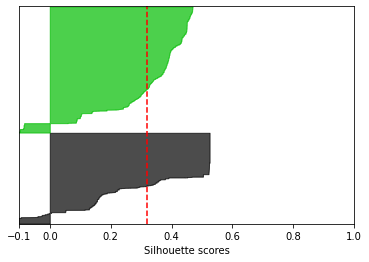

n = 3  : average silhouette_score : 0.445


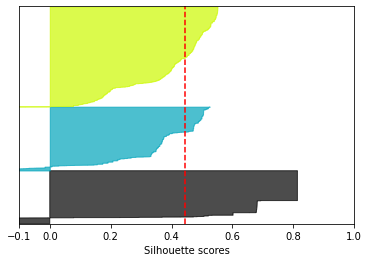

n = 4  : average silhouette_score : 0.4


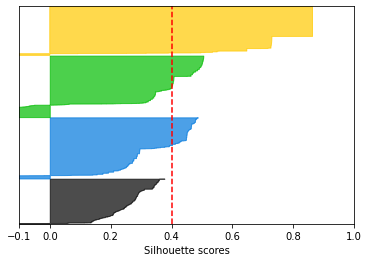

n = 5  : average silhouette_score : 0.432


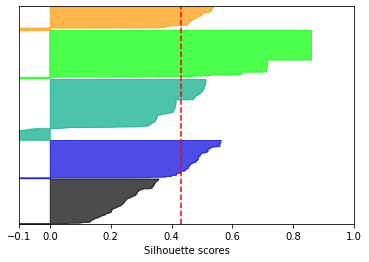

n = 6  : average silhouette_score : 0.515


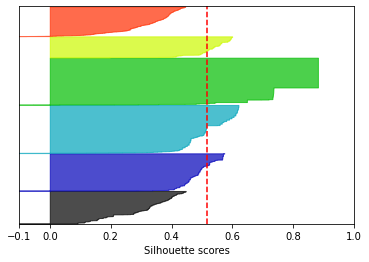

In [23]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = [2, 3, 4, 5, 6]
for n in range_n_clusters:
    plt.xlim([-0.1, 1])
    plt.ylim([0, len(gower_mat) + (n + 1) * 10])
    method = KMedoids(n_clusters = n, random_state = 0, metric = 'precomputed', method = 'pam', init =  'k-medoids++').fit(gower_mat)
    cluster_labels = method.fit_predict(gower_mat)

    avg = silhouette_score(gower_mat, cluster_labels)
    print("n =", n," : average silhouette_score :", round(avg,3))
    sample_values = silhouette_samples(gower_mat, cluster_labels)
    y_lower = 10
    for i in range(n):
        ith_cluster = \
            sample_values[cluster_labels == i]
        ith_cluster.sort()
        size_i = ith_cluster.shape[0]
        y_upper = y_lower + size_i
        color = cm.nipy_spectral(float(i) / n)
        plt.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster,facecolor=color, edgecolor=color, alpha=0.7)
        y_lower = y_upper + 10 
    plt.xlabel("Silhouette scores")
    plt.axvline(x=avg, color="red", linestyle="--")
    plt.yticks([])  
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

# Silhouette internal evaluation for DBSCAN

In [24]:
df.shape

(88435, 8)

In [28]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score


range_min = [10,20,30,50]
range_eps = [0.2,0.4] 
#range_min = [10,20,30,50]
#range_eps = [0.2,0.3]

for m in range_min:
    for e in range_eps:
      method = DBSCAN(eps=e,min_samples=m,metric = "precomputed").fit(gower_mat)
      cluster_labels = method.labels_
      avg = silhouette_score(gower_mat, cluster_labels)
      print("m =",m,"e =",e," : average silhouette_score :", round(avg,3))

m = 10 e = 0.2  : average silhouette_score : 0.422
m = 10 e = 0.4  : average silhouette_score : 0.139
m = 20 e = 0.2  : average silhouette_score : 0.456
m = 20 e = 0.4  : average silhouette_score : 0.139
m = 30 e = 0.2  : average silhouette_score : 0.456
m = 30 e = 0.4  : average silhouette_score : 0.139
m = 50 e = 0.2  : average silhouette_score : 0.485
m = 50 e = 0.4  : average silhouette_score : 0.139


The optimal hyperparameters with highest silhoutte score for DBSCAN were epsilon=0.5 and min_samples=2

# Clusters description

In [29]:
method = DBSCAN(eps=0.2,min_samples=50,metric = "precomputed").fit(gower_mat)
#cluster_labels = method.fit_predict(gower_mat)
cluster_labels = method.labels_
df_clustered = data.assign(Cluster=cluster_labels)
grouped = df_clustered.groupby(['Cluster']).mean().round(1)
grouped

,channel_id,content_type,content_id,geo_location,user_id,day,hour,is_weekday
Cluster,,,,,,,,
-1,1.2,7.2,7.2,829.5,8.9,15.2,14.3,5.4
0,0.0,8.0,-1.0,528.0,0.2,15.8,12.3,4.0
1,0.0,1.5,-1.0,182.9,13.0,15.9,9.6,4.2
2,0.0,5.0,-1.0,8.0,2.0,16.1,12.5,3.1
3,2.0,4.0,-1.0,433.4,7.0,15.9,15.1,3.7
4,1.0,6.0,-1.0,15.0,33.9,15.6,14.1,4.3
5,6.0,4.0,-1.0,223.1,1.0,16.0,2.3,6.9


In [30]:
no_clusters = len(np.unique(cluster_labels) )
no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)
print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 7
Estimated no. of noise points: 161


We are interested in the cluster with id (-1). DBSCAN clusters anomalies to -1 as they do not belong to any other cluster

# Analyzing detected anomalies

In [31]:
import collections
collections.Counter(cluster_labels)[-1]
#161 out of 10000 were detected as anomalies (1.61%)

161

In [32]:
df_clustered.groupby('Cluster')['channel_id'].value_counts()[-1]
#most anomalies had channel_id=0

channel_id
0    118
7     18
1     13
4      9
2      1
3      1
6      1
Name: channel_id, dtype: int64

In [33]:
df_clustered.groupby('Cluster')['content_type'].value_counts()[-1]
#most anomalies had content_type=8

content_type
8    114
6     30
4     15
1      2
Name: content_type, dtype: int64

In [34]:
data['content_type'].value_counts() #overall distribution of content_type values in the sample data

4    3913
5    2217
8    1382
2    1121
6     979
0     386
1       2
Name: content_type, dtype: int64

In [35]:
df_clustered.groupby('Cluster')['geo_location'].value_counts()[-1]
#most anomalies had geo_location=144

geo_location
144     40
1287    23
875     15
1549    14
1586    12
1093     7
1553     5
1352     4
48       3
260      3
271      3
771      3
0        2
1        2
211      2
882      2
63       1
148      1
273      1
281      1
350      1
382      1
498      1
644      1
831      1
883      1
923      1
955      1
974      1
1045     1
1085     1
1090     1
1171     1
1300     1
1407     1
1450     1
1530     1
Name: geo_location, dtype: int64